<a href="https://colab.research.google.com/github/Ruma13/skin_cancer-tl/blob/main/DenseNet121_Fusion_CBAM_PrePool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
fanconic_skin_cancer_malignant_vs_benign_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')

print('Data source import complete.')


In [ ]:
import os
import math
import copy
import time
import numpy as np
from typing import Tuple, Dict, Any
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms, datasets

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


**DATA**

In [ ]:
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

data_dir = "/kaggle/input/skin-cancer-malignant-vs-benign"  # Set your dataset path
batch_size = 32
num_workers = 4
img_size = 224

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}


full_train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "train"),
    transform=data_transforms["train"]
)

val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# ==== LOAD TEST DATASET ====
test_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "test"),
    transform=data_transforms["test"]
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True)

class_names = full_train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)


Classes: ['benign', 'malignant']


**Class Weights And Sampler(Optional)**

In [ ]:
import numpy as np

# Initialize counts
counts = np.zeros(num_classes, dtype=np.int64)

# full_train_dataset is a Subset of ImageFolder, but here we need the original ImageFolder
# full_train_dataset.dataset.imgs gives all (path, label) pairs
for _, label in full_train_dataset.imgs:
    counts[label] += 1

print("Class counts:", counts)

# Compute class weights
class_weights = 1.0 / counts
sample_weights = [class_weights[label] for _, label in full_train_dataset.imgs]

# Weighted sampler
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create train_loader with sampler
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True)


Class counts: [1440 1197]


**CBAM: Channel & Spatial Attention**

In [ ]:

class ChannelAttention(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16):
        super().__init__()
        hidden = max(in_channels // reduction, 1)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, in_channels, bias=False)
        )
        self.pool_avg = nn.AdaptiveAvgPool2d(1)
        self.pool_max = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg = self.pool_avg(x).view(b, c)
        mx  = self.pool_max(x).view(b, c)
        attn = self.mlp(avg) + self.mlp(mx)
        attn = self.sigmoid(attn).view(b, c, 1, 1)
        return x * attn


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int = 7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # channel-wise avg and max
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        feat = torch.cat([avg, mx], dim=1)
        attn = self.sigmoid(self.conv(feat))
        return x * attn


class CBAM(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16, sa_kernel: int = 7):
        super().__init__()
        self.ca = ChannelAttention(in_channels, reduction)
        self.sa = SpatialAttention(sa_kernel)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x


**Model: DenseNet121 Backbone up to layer4 → CBAM → Mid Head → GAP → FC**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class DenseNetCBAMFusion(nn.Module):
    def __init__(self, num_classes: int, unfreeze_last_block: bool = True, mid_channels: int = 1024):
        super().__init__()
        # Load pretrained DenseNet121
        backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        # Take all convolutional features (everything before classifier)
        self.stem = backbone.features  # output: (B, 1024, H/32, W/32)
        in_ch = 1024

        # Freeze all layers by default
        for p in self.stem.parameters():
            p.requires_grad = False

        # Optionally unfreeze last denseblock + transition for fine-tuning
        if unfreeze_last_block:
            for p in list(self.stem[-6:].parameters()):  # last denseblock + transition
                p.requires_grad = True

        # CBAM attention
        self.attn = CBAM(in_ch, reduction=16, sa_kernel=7)

        # Mid head on feature maps (keeps spatial info)
        self.mid = nn.Sequential(
            nn.Conv2d(in_ch, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(mid_channels, num_classes)

    def forward(self, x):
        x = self.stem(x)       # (B, 1024, H/32, W/32)
        x = self.attn(x)       # CBAM on maps
        x = self.mid(x)        # (B, mid, H/32, W/32)
        x = self.pool(x)       # (B, mid, 1, 1)
        x = torch.flatten(x, 1)  # (B, mid)
        logits = self.fc(x)
        return logits

# Initialize model
model = DenseNetCBAMFusion(num_classes=num_classes, unfreeze_last_block=True, mid_channels=1024).to(device)
print(model.__class__.__name__)


DenseNetCBAMFusion


**Optimizer, Loss, and Scheduler**

In [ ]:

epochs = 15
lr = 1e-3
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()   # <-- fixed here

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

**Traning And Early Stopping**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import copy, time
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


batch_size = 32

# Get labels for only the subset used in train_dataset
subset_labels = [full_train_dataset.targets[i] for i in train_dataset.indices]

# Count samples per class
counts = np.bincount(subset_labels, minlength=num_classes)

# Compute class weights (inverse frequency)
class_weights = 1.0 / counts
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Assign a weight to each sample in the subset
sample_weights = [class_weights[label] for label in subset_labels]

# Weighted sampler for training
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

print("DataLoaders ready!")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    return running_loss/total, correct/total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_logits, all_targets = [], []
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = running_loss/total
    acc = correct/total
    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)
    return avg_loss, acc, all_logits, all_targets


def macro_metrics(logits, targets, num_classes):
    preds = logits.argmax(dim=1).numpy()
    y_true = targets.numpy()
    f1 = f1_score(y_true, preds, average="macro", zero_division=0)
    prec = precision_score(y_true, preds, average="macro", zero_division=0)
    rec = recall_score(y_true, preds, average="macro", zero_division=0)

    auc = None
    try:
        if num_classes > 2:
            y_bin = np.eye(num_classes)[y_true]
            auc = roc_auc_score(y_bin, logits.numpy(), multi_class="ovr")
        elif num_classes == 2:
            probs = torch.softmax(torch.from_numpy(logits.numpy()), dim=1).numpy()[:, 1]
            auc = roc_auc_score(y_true, probs)
    except:
        auc = None
    return f1, prec, rec, auc


epochs = 15
lr = 1e-3
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor if num_classes > 1 else None)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

best_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
patience = 7
epochs_no_improve = 0

for epoch in range(1, epochs+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, dataloaders["train"], optimizer, criterion)
    val_loss, val_acc, val_logits, val_targets = evaluate(model, dataloaders["val"], criterion)
    f1, prec, rec, auc = macro_metrics(val_logits, val_targets, num_classes)

    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_cbam_fusion.pt")
    else:
        epochs_no_improve += 1

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{epochs} | {dt:.1f}s "
          f"| tr_loss {tr_loss:.4f} acc {tr_acc:.4f} "
          f"| val_loss {val_loss:.4f} acc {val_acc:.4f} "
          f"| F1 {f1:.4f} P {prec:.4f} R {rec:.4f} "
          f"| AUC {auc if auc is not None else 'NA'}")

    if epochs_no_improve >= patience:
        print("Early stopping.")
        break


model.load_state_dict(best_wts)
test_loss, test_acc, test_logits, test_targets = evaluate(model, dataloaders["test"], criterion)
f1, prec, rec, auc = macro_metrics(test_logits, test_targets, num_classes)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.4f} "
      f"| F1 {f1:.4f} P {prec:.4f} R {rec:.4f} "
      f"| AUC {auc if auc is not None else 'NA'}")


DataLoaders ready!
Train: 2110, Val: 527, Test: 660
Epoch 01/15 | 581.0s | tr_loss 0.4162 acc 0.8109 | val_loss 0.5295 acc 0.8121 | F1 0.8119 P 0.8232 R 0.8291 | AUC 0.8975273911755997
Epoch 02/15 | 584.2s | tr_loss 0.2907 acc 0.8687 | val_loss 0.4668 acc 0.8254 | F1 0.8251 P 0.8339 R 0.8411 | AUC 0.921587207580693
Epoch 03/15 | 603.2s | tr_loss 0.2531 acc 0.8844 | val_loss 0.3322 acc 0.8596 | F1 0.8571 P 0.8549 R 0.8614 | AUC 0.9412644358898431
Epoch 04/15 | 578.8s | tr_loss 0.2365 acc 0.8953 | val_loss 0.4149 acc 0.8482 | F1 0.8479 P 0.8557 R 0.8639 | AUC 0.949185667752443
Epoch 05/15 | 592.5s | tr_loss 0.2008 acc 0.9057 | val_loss 0.3502 acc 0.8767 | F1 0.8751 P 0.8732 R 0.8825 | AUC 0.9493633402428191
Epoch 06/15 | 606.4s | tr_loss 0.1842 acc 0.9199 | val_loss 0.2721 acc 0.8767 | F1 0.8726 P 0.8746 R 0.8710 | AUC 0.9568700029612083
Epoch 07/15 | 596.8s | tr_loss 0.1655 acc 0.9294 | val_loss 0.4248 acc 0.8539 | F1 0.8530 P 0.8550 R 0.8649 | AUC 0.9430929819366303
Epoch 08/15 | 580.7

**Confusion Matrix**

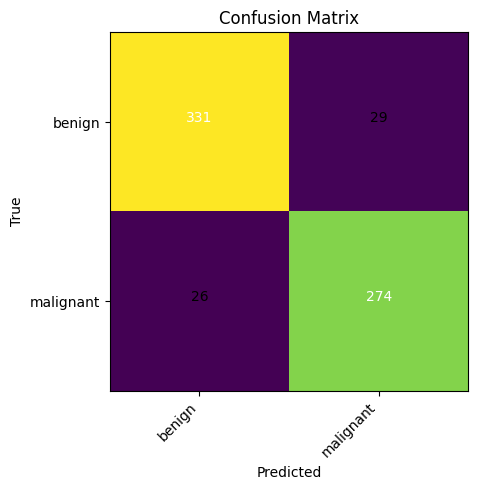

In [ ]:

def plot_confusion_matrix(logits, targets, classes):
    preds = logits.argmax(dim=1).numpy()
    y_true = targets.numpy()
    cm = confusion_matrix(y_true, preds, labels=list(range(len(classes))))

    fig = plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Add counts
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_logits, test_targets, class_names)


In [ ]:
test_loss, test_acc, test_logits, test_targets = evaluate(model, dataloaders["test"], criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3093
Test Accuracy: 0.9167
